In this notebook we'll solve the Bernoulli Bandits problem using the QCLP formulation presented in the paper below:
https://www.ijcai.org/Proceedings/07/Papers/389.pdf

I'll also be borrowing from this video and the code presented in it:
https://www.youtube.com/watch?v=8GuQAfyvWYc&list=PLRwcSE2bmyBxc9u_tV65sZTGy729nqgiv&index=16&ab_channel=ICTPQuantitativeLifeSciences

In [1]:
from pyomo.environ import *
from itertools import product
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import sys
# append a new directory to sys.path
sys.path.append("c:\\Users\\Tassili\\Desktop\\FSC-optimization-main")
from QCLP_formulation import qclp_formulation

# Two-armed Bernoulli Bandits...

* Credits: Andrea Mazzolini, Alberto Pezzotta*

In the standard "two-armed Bernoulli Bandits" we can pull one of the two arms of a bandit (slot-machine) $a\in \lbrace 1,2 \rbrace$. Both the arms provide a Bernoulli-distributed reward: $r = 1$ with probability $q_i$, $r = 0$ with $1-q_i$, where $i \in \lbrace 1,2 \rbrace$.

<div>
<img src="Bandits.PNG" width="400">
</div>

In the most general case, there is a whole 2D space of possible bandits.
Each point correspond to a single state, that is a single realization of the two-bandits above.

<div>
<img src="BeliefSpace.PNG" width="400">
</div>
Solving each problem is trivial: we just use the arm with larger success probability.

In our case we'll choose to focus on two symmetric states (A,B) of this square where we have the following probabilities:
* Probability of winning in state A having chosen action (arm) 1: $P(r = 1 \,|\, s= A, a=1) = \theta$ 
* Probability of winning in state A having chosen action (arm) 2: $P(r = 1 \,|\, s= A, a=2) = 1 - \theta$ 
* Probability of winning in state B having chosen action (arm) 1: $P(r = 1 \,|\, s= B, a=1) = 1 - \theta$ 
* Probability of winning in state B having chosen action (arm) 2: $P(r = 1 \,|\, s= B, a=2) = \theta$ 

Upon choosing $\theta$ we get the two states:

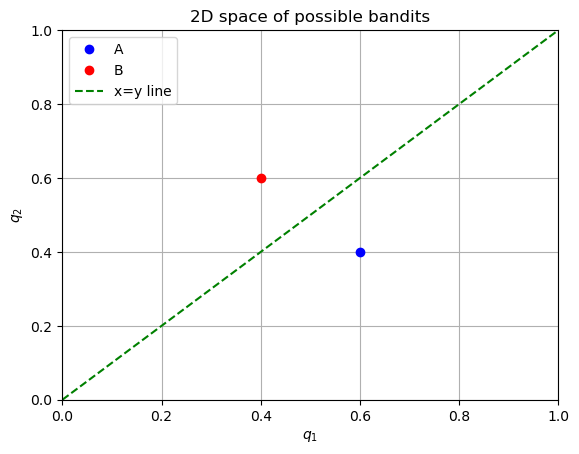

In [2]:
thetatest = 0.6
# Define the coordinates of the two points
point1 = (thetatest, 1- thetatest)
point2 = (1- thetatest, thetatest)

# Extract x and y coordinates of each point
x1, y1 = point1
x2, y2 = point2

# Plot the points
plt.plot(x1, y1, 'bo', label='A')
plt.plot(x2, y2, 'ro', label='B')
plt.plot([0, 1], [0, 1], 'g--', label='x=y line')

# Set plot limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add grid
plt.grid(True)

# Add labels and legend
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')
plt.title('2D space of possible bandits')
plt.legend()

# Show plot
plt.show()


Following this we define our POMDP parameter values

In [3]:
#Define POMDP parameters

num_states = 2 # Number of states
num_actions = 2 # Number of actions
num_observations = 2 # Number of observations

s = list(range(num_states))  # state A & B
a = list(range(num_actions)) # pull arm 1 or pull arm 2
o = list(range(num_observations))  # recieve reward 1 or 0

b0 = np.ones((num_states)) / num_states # uniform initial distribution over states
gamma = 0.9 # Discount factor 
theta = 0.8 # Bernoulli parameter for the reward

# P(s'|s,a) in this case equals 1 when s' = s and 0 otherwise
state_transition_model = np.zeros((num_states, num_actions, num_states)) 
for state, sprime, action in product(s,s,a):
    if state ==  sprime:
        state_transition_model[sprime, action, state] = 1

# R(s,a), since the reward is stochastic we take instead the average reward for each arm and state
reward_model = np.zeros((num_states, num_actions))
# state A
reward_model[0, 0], reward_model[0, 1] = theta, 1 - theta
# state B
reward_model[1, 0], reward_model[1, 1] = 1 - theta, theta

def bernoulliprob(p,y):
    return p**y * (1-p)**(1-y)

# O(o|s',a) the probability of observing reward o in state s' after taking action a
observation_model = np.zeros((num_states, num_actions, num_observations)) 
for state, action, observation in product(s,a,o):
    if state == action:
        observation_model[state,action,observation] = bernoulliprob(theta, observation)
    else:
        observation_model[state,action,observation] = bernoulliprob(1-theta, observation)


Visualizing POMDP parameter values

In [4]:
def statename(state):
    return 'A' if state == 0 else 'B'
state_transition_model_dict = {
    str((statename(sprime),action +1,statename(state))): state_transition_model[sprime,action,state]
    for sprime,action,state in product(s,a,s)
}
state_transition_model_df = pd.DataFrame(state_transition_model_dict, index=['Transition probability']) 
state_transition_model_df.rename_axis("(s',a,s)", axis="columns").T

,Transition probability
"(s',a,s)",
"('A', 1, 'A')",1.0
"('A', 1, 'B')",0.0
"('A', 2, 'A')",1.0
"('A', 2, 'B')",0.0
"('B', 1, 'A')",0.0
"('B', 1, 'B')",1.0
"('B', 2, 'A')",0.0
"('B', 2, 'B')",1.0


In [5]:
rewarddf = pd.DataFrame(reward_model, index=['A', 'B'], columns=['Arm 1', 'Arm 2'])
rewarddf.rename_axis("state", axis="index")

,Arm 1,Arm 2
state,,
A,0.8,0.2
B,0.2,0.8


In [6]:
observation_model_dict = {
    (str((statename(sprime),action +1,observation))): observation_model[sprime,action,observation]
    for sprime,action,observation in product(s,a,o) }
observation_model_df = pd.DataFrame(observation_model_dict, index=['Observation probability']).T
observation_model_df.rename_axis("(s',a,o)", axis="index")

,Observation probability
"(s',a,o)",
"('A', 1, 0)",0.2
"('A', 1, 1)",0.8
"('A', 2, 0)",0.8
"('A', 2, 1)",0.2
"('B', 1, 0)",0.8
"('B', 1, 1)",0.2
"('B', 2, 0)",0.2
"('B', 2, 1)",0.8


FSC

In [13]:
num_nodes = 1
q = list(range(num_nodes)) # Nodes in the FSC


# QCLP formulation
<div>
<img src="QCLP formulation.PNG" width="850">
</div>
Where the variable $x(q', a, q, o)$ represents $P(q', a|q, o)$, variable $y(q, s)$
represents $V(q, s)$, $q_0$ is the initial controller node and $o_k$ is an arbitrary fixed observation

Note that $P(q', a|q, o)= P(q'|q, o) P(a|q)$ 

And $\sum{q'} P(q', a|q, o) = P(a|q)$

In [14]:
newmodel = qclp_formulation(num_states, num_actions, num_observations, num_nodes, b0, gamma, state_transition_model, reward_model, observation_model)

In [15]:
opt = SolverFactory('ipopt')
res = opt.solve(newmodel) 
print(res.write())

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 6
  Number of variables: 6
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.0829308032989502
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
None


In [16]:
newmodel.y.pprint()

y : Size=2, Index=y_index
    Key    : Lower : Value              : Upper : Fixed : Stale : Domain
    (0, 0) :  None :  4.999999999996204 :  None : False : False :  Reals
    (0, 1) :  None : 4.9999999999961275 :  None : False : False :  Reals


In [17]:
newmodel.x.pprint()

x : Size=4, Index=x_index
    Key          : Lower : Value               : Upper : Fixed : Stale : Domain
    (0, 0, 0, 0) :   0.0 :  0.4999999999999895 :   1.0 : False : False :  Reals
    (0, 0, 0, 1) :   0.0 : 0.49999999999999045 :   1.0 : False : False :  Reals
    (0, 1, 0, 0) :   0.0 :  0.4999999999999756 :   1.0 : False : False :  Reals
    (0, 1, 0, 1) :   0.0 : 0.49999999999997646 :   1.0 : False : False :  Reals


# Checking code
for the following values:

number of states: 2

number of actions: 2

number of observations: 2

$\theta = 0.8$, $\gamma = 0.5$, $b_0 = (0.5, 0.5)$

Reward model:

$R(s = A, a = 1) = P(r = 1 \,|\, s= A, a=1) = \theta$  

$R(s = A, a = 2) = P(r = 1 \,|\, s= A, a=2) = 1 - \theta$ 

$R(s = B, a = 1) = P(r = 1 \,|\, s= B, a=1) = 1 - \theta$ 

$R(s = B, a = 2) = P(r = 1 \,|\, s= B, a=2) = \theta$ 

State transition model:

$P(s'|s, a) = \mathbb{1}_{s=s'}$ 

Observation model:

$O(o = 1|s' = A,a = 1) = \theta$

$O(o = 1|s' = A,a = 2) = 1 - \theta$

$O(o = 1|s' = B,a = 1) = 1 - \theta$

$O(o = 1|s' = B,a = 2) = \theta$

#### Objective function given by the code:

obj = $0.5*y(0,0) + 0.5*y(0,1)$

#### Constraints:

##### Bellman constraint:

for $q = 0, s = 0$: 

$y[0,0] = (0.8*x[0,0,0,0] + 0.5*(0.2*x[0,0,0,0]*y[0,0] + 0.0*x[0,0,0,0]*y[0,1] + 0.8*x[0,0,0,1]*y[0,0] + 0.0*x[0,0,0,1]*y[0,1])   + 0.2*x[0,1,0,0] + 0.5*(0.8*x[0,1,0,0]*y[0,0] + 0.0*x[0,1,0,0]*y[0,1] + 0.2*x[0,1,0,1]*y[0,0] + 0.0*x[0,1,0,1]*y[0,1]))$

 for $q = 0, s = 1:$
 
 $y[0,1] = (0.2*x[0,0,0,0] + 0.5*(0.0*x[0,0,0,0]*y[0,0] + 0.8*x[0,0,0,0]*y[0,1] + 0.0*x[0,0,0,1]*y[0,0] + 0.2*x[0,0,0,1]*y[0,1]) + 0.8*x[0,1,0,0] + 0.5*(0.0*x[0,1,0,0]*y[0,0] + 0.2*x[0,1,0,0]*y[0,1] + 0.0*x[0,1,0,1]*y[0,0] + 0.8*x[0,1,0,1]*y[0,1]))$

 ##### Sum over action and resulting node:

 for $q = 0, o = 0:$

 $x[0,0,0,0] + x[0,1,0,0] == 1$

 for $q = 0, o = 1:$

 $x[0,0,0,1] + x[0,1,0,1] == 1$

 ##### Independence of observation:

 $o_k = 0$
 
for $q = 0, a = 0, o = 0$  
$x[0,0,0,0] == x[0,0,0,0]$

for $q = 0, a = 1, o = 0$  
$x[0,1,0,0] == x[0,1,0,0]$ 

for $q = 0, a = 0, o = 1$  
$x[0,0,0,1] ==  x[0,0,0,0]$ 

for $q = 0, a = 1, o = 1$  
$x[0,1,0,1] == x[0,1,0,0]$ 